In [8]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from operator import itemgetter
from time import time
import matplotlib.pyplot as plt
import glob
import pickle
import tabulate

import sklearn
%matplotlib inline

# Utils

In [9]:
def draw_boxes(img, bboxes, color = [0, 0, 255], thickness = 6):
    cl = color
    for (tl, br) in bboxes:
        if color == None:
            cl = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
        cv2.rectangle(img, tl, br, cl, thickness)

# Load Data

12


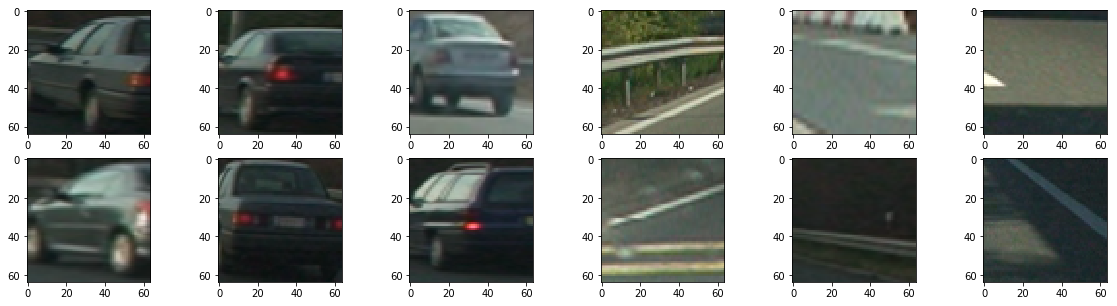

In [10]:
images = glob.glob('data/vehicles/**/*')[:6] + glob.glob('data/non-vehicles/**/*')[:6]
grid = (2, 6)
coors = np.vstack(np.mgrid[:grid[0], :grid[1]].T)
data = []
f = plt.figure(figsize = (20, 5))
for idx, iname in enumerate(images):
    img = cv2.imread(iname)
    axis = plt.subplot2grid(grid, coors[idx])
    img = img[:, :, ::-1]
    axis.imshow(img)
    data.append(img)

print(len(data))

# Feature Extraction

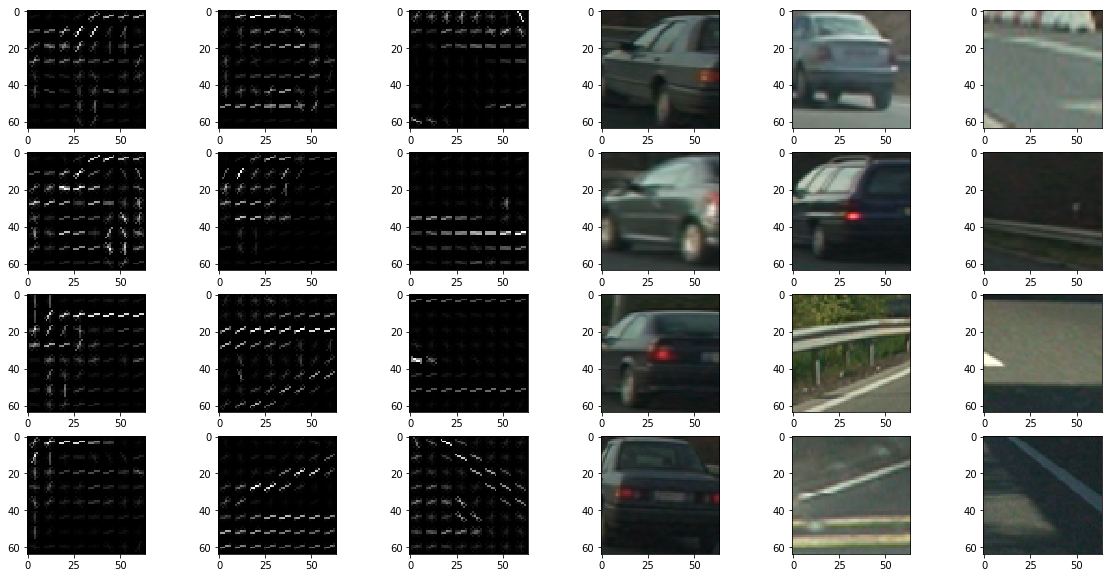

In [11]:
from skimage.feature import hog

orient = 9
pix_per_cell = 8
cell_per_block = 2

def extract_hog_features(img, cspace = None, orient = orient, pix_per_cell = pix_per_cell, 
                     cell_per_block = cell_per_block, feature_vec = True, debug = False):
    hog_image = None
    img = np.copy(img)
    if cspace != None:
        img = cv2.cvtColor(img, cspace)
    
    features = []
    visual = []
    for channel in range(img.shape[-1]):
        if debug:
            hog_features, hog_image = hog(
                img[:, :, channel], 
                orientations = orient, 
                pixels_per_cell = (pix_per_cell, pix_per_cell), 
                cells_per_block = (cell_per_block, cell_per_block),
                visualise = True,
                feature_vector = feature_vec,
                transform_sqrt = False,
                block_norm = 'L2-Hys'
            )
        else:
            hog_features = hog(
                img[:, :, channel], 
                orientations = orient, 
                pixels_per_cell = (pix_per_cell, pix_per_cell), 
                cells_per_block = (cell_per_block, cell_per_block),
                visualise = False,
                feature_vector = feature_vec,
                transform_sqrt = False,
                block_norm = 'L2-Hys'
            )
        features.append(hog_features)
        visual.append(hog_image)

    if feature_vec:
        return np.ravel(features), np.dstack(visual)
    else:
        return features, np.dstack(visual)
    
def extract_color_features(img, size = (32, 32)):
    features = []
    for channel in range(img.shape[-1]):
        ch_feature = cv2.resize(img[:, :, channel], size).ravel()
        features.append(ch_feature)
    return np.array(features)

def extract_hist_features(img, nbins = 32, ranges = (0, 256)):
    features = []
    for channel in range(img.shape[-1]):
        features.append(cv2.calcHist(img, [channel], None, (nbins, ), ranges))
    return np.array(features)

def extract_features(img, cspace = None, orient = orient, pix_per_cell = pix_per_cell, 
                     cell_per_block = cell_per_block, spatial_bin = (32, 32), nbins = 32, ranges = (0, 256)):
    color_features = extract_color_features(img, spatial_bin).ravel()
    hist_features = extract_hist_features(img, nbins, ranges).ravel()
    hog_features, _ = extract_hog_features(img, cspace, orient, pix_per_cell, cell_per_block)

    return np.concatenate((color_features, hist_features, hog_features))

f = plt.figure(figsize = (20, 10))
grid = (4, 6)
coors = np.vstack(np.mgrid[:grid[0], :grid[1]].T)
for idx, img in enumerate(data):
    features, output = extract_hog_features(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).reshape(*img.shape[:2], 1)
                                        , debug = True)
    ax = plt.subplot2grid(grid, coors[idx])
    ax.imshow(output.squeeze(), cmap = 'gray')
    ax = plt.subplot2grid(grid, coors[idx + (grid[1] * grid[0] // 2)])
    ax.imshow(img)

# Augment and Split data

In [15]:
car_files = glob.glob('data/vehicles/**/*')
noncar_files = glob.glob('data/non-vehicles/**/*')

# Experiment with histogram comparison
car_labels = []
cars = []
car_cls = 1
prev_hist = None
# Deal with time-series data in GTI by using histogram comparison
for idx, iname in enumerate(car_files):
    img = cv2.imread(iname)
    hist = extract_hist_features(img).ravel()
    if idx != 0:
        score = cv2.compareHist(prev_hist, hist, cv2.HISTCMP_CORREL)
        if score < 0.5:
            car_cls += 1
    prev_hist = hist
    car_labels.append(car_cls)
    cars.append(iname)
    
noncars = []
for idx, iname in enumerate(noncar_files):
    noncars.append(iname)

# Split using car labels to ensure class distributions
# sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.35, random_state = SEED)

# X, y = np.concatenate([cars, noncars]), np.concatenate([car_labels, noncar_labels])
# # Make sure we have correct distribution
# for train_index, test_index in sss.split(X, y):
#     train_y = y[train_index]
#     test_y = y[test_index]

# f, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))

# # plot test, train class distributions in log scale
# hist, edges = np.histogram(train_y)
# centers = np.round(np.log((edges[1:] - edges[0:-1]) / 2.0 + edges[1:]), 1)
# inds = np.arange(len(centers)) * 4
# ax1.bar(inds, np.log(hist), width = 2)
# ax1.xaxis.set_ticklabels(centers)
# ax1.xaxis.set_ticks(inds)

# hist, edges = np.histogram(test_y)
# centers = np.round(np.log((edges[1:] - edges[0:-1]) / 2.0 + edges[1:]), 1)
# inds = np.arange(len(centers)) * 4
# ax2.bar(inds, np.log(hist), width = 2)
# ax2.xaxis.set_ticklabels(centers)
# ax2.xaxis.set_ticks(inds)

print(len(cars), len(noncars))

8792 8968


# Train a classifier

In [18]:
orient = [9, 11, 12]
pix_per_cell = [8, 16]
cspace_name = ['BGR', 'YUV', 'YCrCb', 'RGB', 'HSV', 'HLS']
cspace = [None, cv2.COLOR_BGR2YUV, cv2.COLOR_BGR2YCrCb, cv2.COLOR_BGR2RGB, cv2.COLOR_BGR2HSV, cv2.COLOR_BGR2HLS]
headers = ['Orient', 'Pix p/ Cell', 'Color', 
           'Time Train', 'Accuracy', 'Time Predict', 'Time Extract']
table = []
SEED = 82

def flag_odd_index(x):
    return zip(x, [bool(i & 1) for i in range(len(x))])

def read_images(x):
    return [cv2.imread(iname) for iname in x]

def serialize_model(model, cspace, orient, pix_per_cell, cell_per_block):
    joblib.dump(model, 'model_{}_{}_{}_{}.pkl'.format(orient, pix_per_cell, cell_per_block, cspace))
    
def deserialize_model(cspace, orient, pix_per_cell, cell_per_block):
    return joblib.load('model_{}_{}_{}_{}.pkl'.format(orient, pix_per_cell, cell_per_block, cspace))

sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.35, random_state = SEED)

scaler = StandardScaler()
svc = LinearSVC()
model = make_pipeline(scaler, svc)

cars_img = read_images(cars)

noncars_img = read_images(noncars)

STRATIFIED = True
FLIP = True
FORCE_TRAIN = True

car_data_labels = list(car_labels)
if FLIP:
    car_data_labels = car_data_labels * 2
    cars_img.extend([np.fliplr(img) for img in cars_img])
    noncars_img.extend([np.fliplr(img) for img in noncars_img])
    sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = SEED)

if STRATIFIED:
    y = list(car_data_labels)
    y.extend([0 for _ in noncars_img])
    y = np.array(y)
    # Split train test with even class distributions
    try:
        train_idx, test_idx = next(sss.split(range(len(cars_img) + len(noncars_img)), y))
    except ValueError:
        uniq_val, uniq_idx, uniq_cnt = np.unique(y, return_index = True, return_counts = True)
        one_idx = uniq_idx[uniq_cnt == 1]
        cars_img.extend([np.fliplr(cars_img[car_idx]) for car_idx in one_idx])
        noncars_img.extend([np.fliplr(img) for img in noncars_img[:len(one_idx)]])

        y = np.concatenate((car_data_labels, y[one_idx], [0 for _ in noncars_img]))
        train_idx, test_idx = next(sss.split(range(len(cars_img) + len(noncars_img)), y))

    # make classes binary for classification
    y[y > 1] = 1
    train_y, test_y = y[train_idx], y[test_idx]
else:
    y = np.hstack((np.ones(len(cars_img)), np.zeros(len(noncars_img))))
    
def stream_converted_images(cars, noncars, color_cvt):
    for car in cars:
        yield cv2.cvtColor(car, color_cvt)
    for noncar in noncars:
        yield cv2.cvtColor(noncar, color_cvt)

c = 2
# Choose o = 11, p = 16, cspace = YUV
for idx in range(len(cspace))[1:3]:
    t1 = time()
    X = [[] for img in stream_converted_images(cars_img, noncars_img, cspace[idx])]
    for img_idx, img in enumerate(stream_converted_images(cars_img, noncars_img, cspace[idx])):
        X[img_idx].extend(extract_color_features(img).ravel())
    color_n = len(X[0])
    for img_idx, img in enumerate(stream_converted_images(cars_img, noncars_img, cspace[idx])):
        X[img_idx].extend(extract_hist_features(img).ravel())
    hist_n = len(X[0]) - color_n
    t2 = time()
    extract_t_pre = t2 - t1
    for o in orient[1:2]:
        for p in pix_per_cell[1:]:
            train_t = -1

            t1 = time()
            for img_idx, img in enumerate(stream_converted_images(cars_img, noncars_img, cspace[idx])):
                X[img_idx].extend(extract_hog_features(img, None, o, p, c)[0])
            X = np.array(X)
            hog_n = len(X[0]) - hist_n - color_n
            t2 = time()
            extract_t = (t2 - t1) + extract_t_pre
            print('Extract in {:2f} seconds'.format(extract_t))
            print('Training {} parameters: {} color, {} hist, {} hog'.format(X[0].shape, color_n, hist_n, hog_n))

            if STRATIFIED:
                train_X, test_X = X[train_idx], X[test_idx]
            else:
                train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = SEED)
            
            
            print('Train size {} samples; Test size {} samples'.format(len(train_X), len(test_X)))
            if not FORCE_TRAIN:
                try:
                    model = deserialize_model(cspace_name[idx], o, p, c)
                except:
                    t1 = time()
                    model.fit(train_X, train_y)
                    t2 = time()
                    train_t = t2 - t1
                    print('Train in {} seconds'.format(train_t))
                    # persist model
                    serialize_model(model, cspace_name[idx], o, p, c)
            else:
                t1 = time()
                model.fit(train_X, train_y)
                t2 = time()
                train_t = t2 - t1
                print('Train in {} seconds'.format(train_t))
                # persist model
                serialize_model(model, cspace_name[idx], o, p, c)
                
            # Check the score of the SVC
            score = model.score(test_X, test_y)
            print('Test Accuracy {}'.format(round(score, 6)))
            
            t1 = time()
            n_samples = 10
            print('Predictions: {}'.format(model.predict(test_X[0:n_samples])))
            print('Labels: {}'.format(test_y[0:n_samples]))
            t2 = time()
            pred_t = t2 - t1
            print('{} seconds'.format(pred_t))
            
            row = [o, p, cspace_name[idx], '{:.2f}'.format(train_t), 
                   '{:.6f}'.format(score), '{:2f}'.format(pred_t), '{:2f}'.format(extract_t)]
            table.append(row)
            print('----')

sorted_table = sorted(table, key = itemgetter(4), reverse = True)
sorted_table = sorted(sorted_table, key = itemgetter(6, 3))
table_out = tabulate.tabulate([headers] + sorted_table, headers = 'firstrow', tablefmt = 'pipe')
print(table_out)

Extract in 110.119380 seconds
Training (4356,) parameters: 3072 color, 96 hist, 1188 hog
Train size 18480 samples; Test size 9952 samples
Train in 15.897266626358032 seconds
Test Accuracy 0.983722
Predictions: [0 1 0 0 1 0 1 0 1 1]
Labels: [0 1 0 0 1 0 1 0 1 1]
0.001737356185913086 seconds
----
|   Orient |   Pix p/ Cell | Color   |   Time Train |   Accuracy |   Time Predict |   Time Extract |
|---------:|--------------:|:--------|-------------:|-----------:|---------------:|---------------:|
|       11 |            16 | YUV     |         15.9 |   0.983722 |       0.001737 |        110.119 |


# Parameter Exploration

Here we see that orient = 11, Pix/ Cell = 16, Color space = YUV, cell / block = 2 is the best performing parameters.
(Note the first few rows were missing time training because the code didn't output the time yet)

|   Orient |   Pix p/ Cell | Color   |   Time Train |   Accuracy |   Time Predict |   Time Extract |
|---------:|--------------:|:--------|-------------:|-----------:|---------------:|---------------:|
|        9 |             8 | BGR     |           -1 |       0.95 |       0.002241 |       125.517  |
|        9 |             8 | YUV     |           -1 |       0.96 |       0.002145 |       127.722  |
|        9 |             8 | RGB     |           -1 |       0.95 |       0.002098 |       130.415  |
|        9 |             8 | HSV     |           -1 |       0.95 |       0.001986 |       124.824  |
|        9 |             8 | HLS     |           -1 |       0.94 |       0.002151 |       122.791  |
|        9 |            16 | BGR     |           -1 |       0.79 |       0.001468 |        64.0433 |
|        9 |            16 | YUV     |           -1 |       0.87 |       0.001546 |        62.132  |
|        9 |            16 | RGB     |           -1 |       0.79 |       0.001746 |        63.0466 |
|        9 |            16 | HSV     |           -1 |       0.78 |       0.003027 |        65.1753 |
|        9 |            16 | HLS     |           -1 |       0.77 |       0.004772 |        67.5552 |
|       11 |             8 | BGR     |        95.5  |       0.94 |       0.002221 |       127.604  |
|       11 |             8 | YUV     |        61.14 |       0.96 |       0.00211  |       127.016  |
|       11 |             8 | RGB     |        95.42 |       0.94 |       0.002319 |       129.652  |
|       11 |             8 | HSV     |        83.63 |       0.95 |       0.002076 |       137.099  |
|       11 |             8 | HLS     |        89.15 |       0.95 |       0.002218 |       132.62   |
|       11 |            16 | BGR     |        17.43 |       0.95 |       0.004175 |        68.1027 |
|       11 |            16 | YUV     |         6.92 |       0.97 |       0.002062 |        69.2562 |
|       11 |            16 | RGB     |        17.08 |       0.95 |       0.001493 |        67.7792 |
|       11 |            16 | HSV     |         9.84 |       0.97 |       0.001969 |        75.3546 |
|       11 |            16 | HLS     |        10    |       0.96 |       0.001521 |        73.9208 |
|       12 |             8 | BGR     |        95.4  |       0.95 |       0.002617 |       132.813  |
|       12 |             8 | YUV     |        62.21 |       0.97 |       0.002151 |       132.003  |
|       12 |             8 | RGB     |        94.24 |       0.95 |       0.002296 |       131.094  |
|       12 |             8 | HSV     |        85.57 |       0.95 |       0.002405 |       132.394  |
|       12 |             8 | HLS     |        84.13 |       0.95 |       0.002313 |       131.651  |
|       12 |            16 | BGR     |        15.2  |       0.95 |       0.001508 |        66.7208 |
|       12 |            16 | YUV     |          7.6 |       0.98 |       0.004925 |        113.474 |
|       12 |            16 | RGB     |        14.91 |       0.95 |       0.001493 |        68.6432 |
|       12 |            16 | HSV     |         9.52 |       0.97 |       0.008444 |        78.2763 |
|       12 |            16 | HLS     |         9.28 |       0.96 |       0.002115 |        82.2828 |

# Search for cars

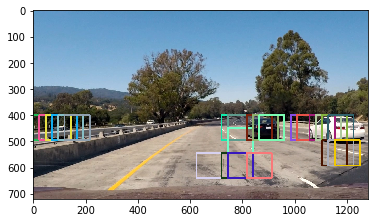

In [8]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, yrange, xrange, scale, model, cspace, orient, pix_per_cell, cell_per_block, draw = False):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    
    img_inp = cv2.cvtColor(img[yrange[0]:yrange[1],xrange[0]:xrange[1],:], cspace)
    if scale != 1:
        imshape = img_inp.shape
        img_inp = cv2.resize(img_inp, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1, ch2, ch3 = img_inp[:, :, 0:1], img_inp[:, :, 1:2], img_inp[:, :, 2:3]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_stepx = 1  # Instead of overlap, define how many cells to step
    cells_per_stepy = 2  # Instead of overlap, define how many cells to step

    nxsteps = (nxblocks - nblocks_per_window) // cells_per_stepx + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_stepy + 1
    
    if not draw:
        # Compute individual channel HOG features for the entire image
        hog1 = extract_features(ch1, orient = orient,
                                        pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                                        feature_vec=False)[0][0]
        hog2 = extract_features(ch2, orient = orient,
                                        pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                                        feature_vec=False)[0][0]
        hog3 = extract_features(ch3, orient = orient,
                                        pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                                        feature_vec=False)[0][0]
    
    rects = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_stepy
            xpos = xb*cells_per_stepx
            
            if not draw:
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                test_prediction = model.predict([hog_features])

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            if draw or test_prediction[0] == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rects.append(((xbox_left + xrange[0], ytop_draw+yrange[0]),(xbox_left+win_draw+xrange[0],ytop_draw+win_draw+yrange[0])))
    draw_boxes(draw_img, rects)
    return draw_img, rects
    
yrange = (400, 656)
scale = 1.5
orient = 11
pix_per_cell = 16
cell_per_block = 2
cspace = cv2.COLOR_BGR2YUV

model = deserialize_model('YUV', orient, pix_per_cell, cell_per_block)

img = cv2.imread('test_images/test1.jpg')
out_img, rects = find_cars(img, yrange, (0, img.shape[1]), scale, model, cspace, orient, pix_per_cell, cell_per_block)


rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
draw_boxes(rgb, rects, color = None)
plt.imshow(rgb)

# Different scale in windows to optimize for depth of field

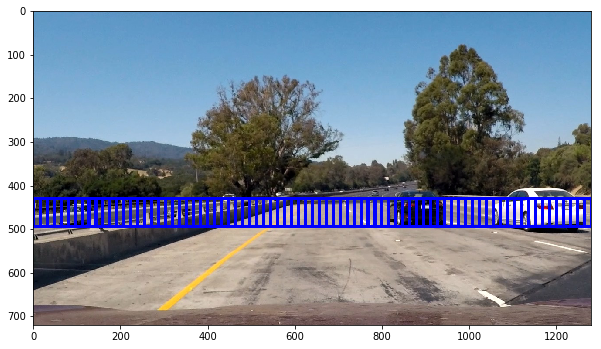

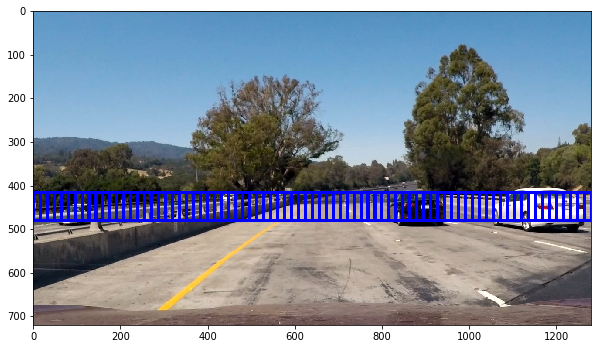

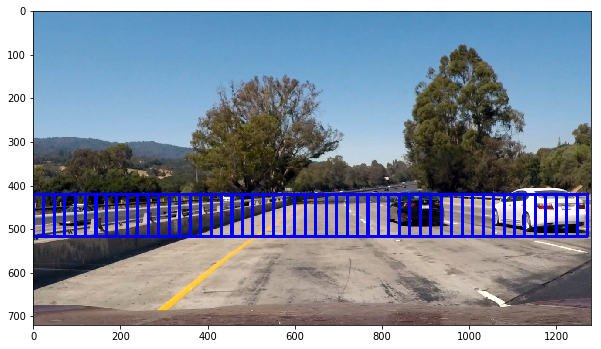

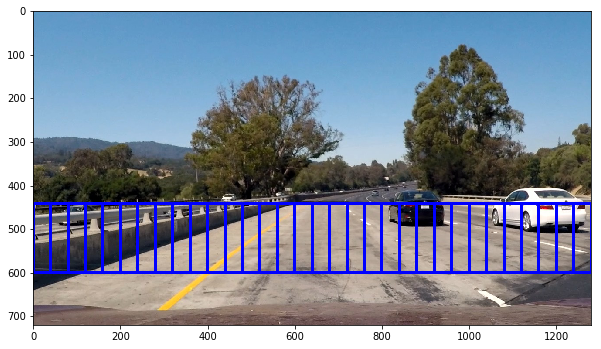

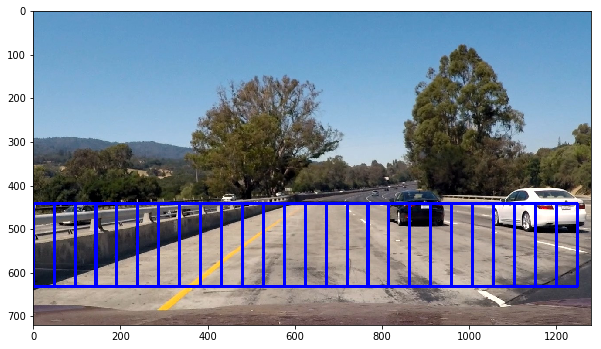

In [52]:
orient = 11
pix_per_cell = 16
cell_per_block = 2
cspace = cv2.COLOR_BGR2YUV
img = cv2.imread('test_images/test1.jpg')
model = deserialize_model('YUV', orient, pix_per_cell, cell_per_block)

def search_with_windows(img, orient, pix_per_cell, cell_per_block, cspace, model, draw = False):
    res = []
    
#     ystart = 400
#     scale = 0.7
#     ystop = ystart + round(scale * 64)
#     rects = find_cars(img, ystart, ystop, scale, model, cspace, orient, pix_per_cell, cell_per_block, draw = draw)[1]
#     res.append(rects)
    
#     if draw:
#         out_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         draw_boxes(out_img, rects)
#         f = plt.figure(figsize = (10, 10))
#         plt.imshow(out_img)

    scale = 1
    yrange = (430, 430 + round(scale * 64))
    cropx = (0, 1)
    xrange = (int(img.shape[1] * cropx[0]), int(img.shape[1] * cropx[1]))

    rects = find_cars(img, yrange, xrange, scale, model, cspace, orient, pix_per_cell, cell_per_block, draw = draw)[1]
    res.append(rects)
    
    if draw:
        out_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        draw_boxes(out_img, rects)
        f = plt.figure(figsize = (10, 10))
        plt.imshow(out_img)

    scale = 1
    yrange = (415, 415 + round(scale * 64))
    cropx = (0, 1)
    xrange = (int(img.shape[1] * cropx[0]), int(img.shape[1] * cropx[1]))

    rects = find_cars(img, yrange, xrange, scale, model, cspace, orient, pix_per_cell, cell_per_block, draw = draw)[1]
    res.append(rects)
    
    if draw:
        out_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        draw_boxes(out_img, rects)
        f = plt.figure(figsize = (10, 10))
        plt.imshow(out_img)

    scale = 1.5
    yrange = (420, 420 + round(scale * 64))
    cropx = (0, 1)
    xrange = (int(img.shape[1] * cropx[0]), int(img.shape[1] * cropx[1]))

    rects = find_cars(img, yrange, xrange, scale, model, cspace, orient, pix_per_cell, cell_per_block, draw = draw)[1]
    res.append(rects)
    
    if draw:
        out_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        draw_boxes(out_img, rects)
        f = plt.figure(figsize = (10, 10))
        plt.imshow(out_img)

    scale = 2.5
    yrange = (440, 440 + round(scale * 64))
    cropx = (0, 1)
    xrange = (int(img.shape[1] * cropx[0]), int(img.shape[1] * cropx[1]))

    rects = find_cars(img, yrange, xrange, scale, model, cspace, orient, pix_per_cell, cell_per_block, draw = draw)[1]
    res.append(rects)
    
    if draw:
        out_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        draw_boxes(out_img, rects)
        f = plt.figure(figsize = (10, 10))
        plt.imshow(out_img)

    scale = 3
    yrange = (440, 440 + round(scale * 64))
    cropx = (0, 1)
    xrange = (int(img.shape[1] * cropx[0]), int(img.shape[1] * cropx[1]))

    rects = find_cars(img, yrange, xrange, scale, model, cspace, orient, pix_per_cell, cell_per_block, draw = draw)[1]
    res.append(rects)
    
    if draw:
        out_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        draw_boxes(out_img, rects)
        f = plt.figure(figsize = (10, 10))
        plt.imshow(out_img)
        
    return res

boxes = search_with_windows(img, orient, pix_per_cell, cell_per_block, cspace, model, draw = True)

# Make predictions with multiple window scales

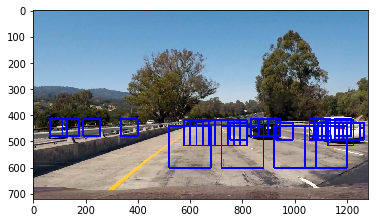

In [53]:
img = cv2.imread('test_images/test1.jpg')
orient = 11
pix_per_cell = 16
cell_per_block = 2
cspace = cv2.COLOR_BGR2YUV
model = deserialize_model('YUV', orient, pix_per_cell, cell_per_block)

windows = search_with_windows(img, orient, pix_per_cell, cell_per_block, cspace, model)
boxes = [rect for window in windows for rect in window]

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
draw_img = np.copy(rgb)
draw_boxes(draw_img, boxes)
plt.imshow(draw_img)

# Heat map functions to detect false positives

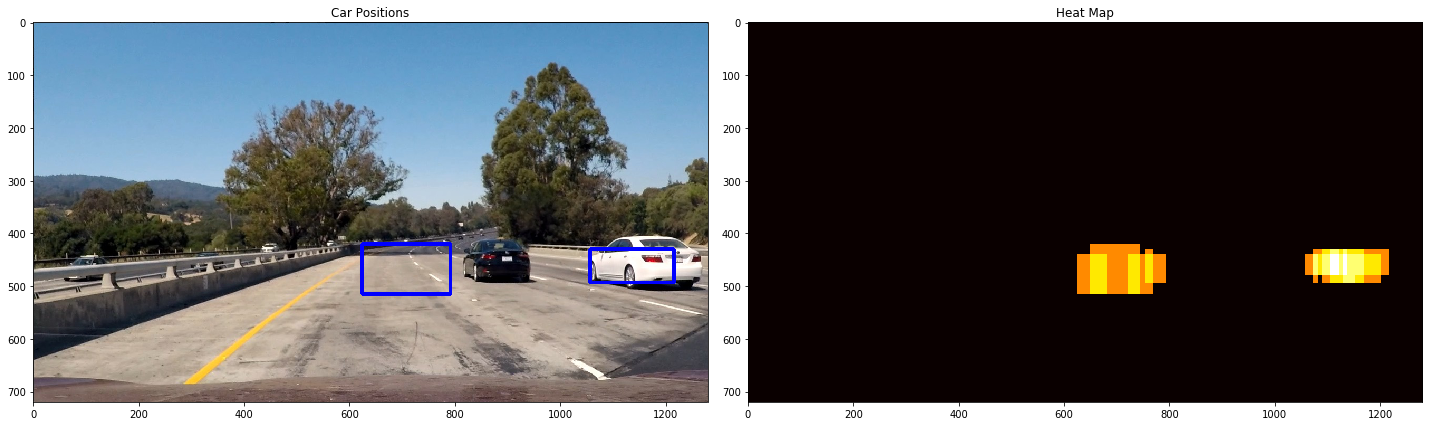

In [54]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

img = cv2.imread('test_images/test1.jpg')
windows = search_with_windows(img, orient, pix_per_cell, cell_per_block, cspace, model)
boxes = [rect for window in windows for rect in window]
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

heat = np.zeros_like(img[:, :, 0])

# Add heat to each box in box list
heat = add_heat(heat, boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = np.copy(rgb)
draw_img = draw_labeled_bboxes(draw_img, labels)

fig = plt.figure(figsize = (20, 10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

    # Pipeline to process video frame


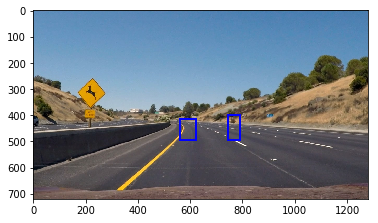

In [28]:
orient = 11
pix_per_cell = 16
cell_per_block = 2
cspace = cv2.COLOR_RGB2YUV

class DetectPipeline:
    def __init__(self, model, orient, pix_per_cell, cell_per_block, cspace, n_frames = 10):
        self.model = model
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.cspace = cspace
        self.n_frames = n_frames
        self.frames = []
        self.cnt = 0

    def detect(self, img):
        self.cnt += 1
        windows = search_with_windows(img, orient, pix_per_cell, cell_per_block, cspace, model)
        boxes = [rect for window in windows for rect in window]
        
        # Remember frame
        self.frames.append(boxes)
        
        # Remove frame when we have over self.n_frames
        if len(self.frames) > self.n_frames:
            self.frames = self.frames[1:]

        heat = np.zeros_like(img[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        for frame in self.frames:
            heat = add_heat(heat, frame)


        # Apply threshold to help remove false positives
        heatmap = apply_threshold(np.copy(heat), sum(len(frame) for frame in self.frames) // 5 + 1)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
                    
        if self.cnt == 6:
            z_heat = np.zeros_like(img[:, :, 0].astype(np.float))
            frame_heats = [add_heat(np.copy(z_heat), frame) for frame in self.frames]
            f = plt.figure(figsize = (20, 5))
            grid = (1, 6)
            coors = np.vstack(np.mgrid[:grid[0], :grid[1]].T)
            for idx, frame_heat in enumerate(frame_heats):
                axis = plt.subplot2grid(grid, coors[idx])
                axis.imshow(frame_heat, cmap = 'hot')
            f = plt.figure(figsize = (20, 10))
            plt.imshow(heat, cmap = 'hot')
            
            f = plt.figure(figsize = (20, 10))
            plt.imshow(draw_img)
            
        return draw_img
    
    def reset():
        self.frames = []
    
model = deserialize_model('YUV', orient, pix_per_cell, cell_per_block)
n_frames = 10

pipeline = DetectPipeline(model, orient, pix_per_cell, cell_per_block, cspace, n_frames)
img = cv2.imread('test_images/test2.jpg')[:, :, ::-1]
plt.imshow(pipeline.detect(img))

# Process Video

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:13<00:00,  2.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 20.9 s, sys: 182 ms, total: 21.1 s
Wall time: 15 s


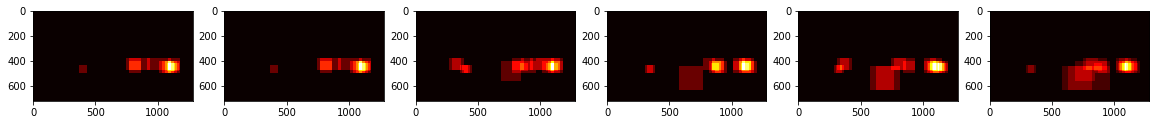

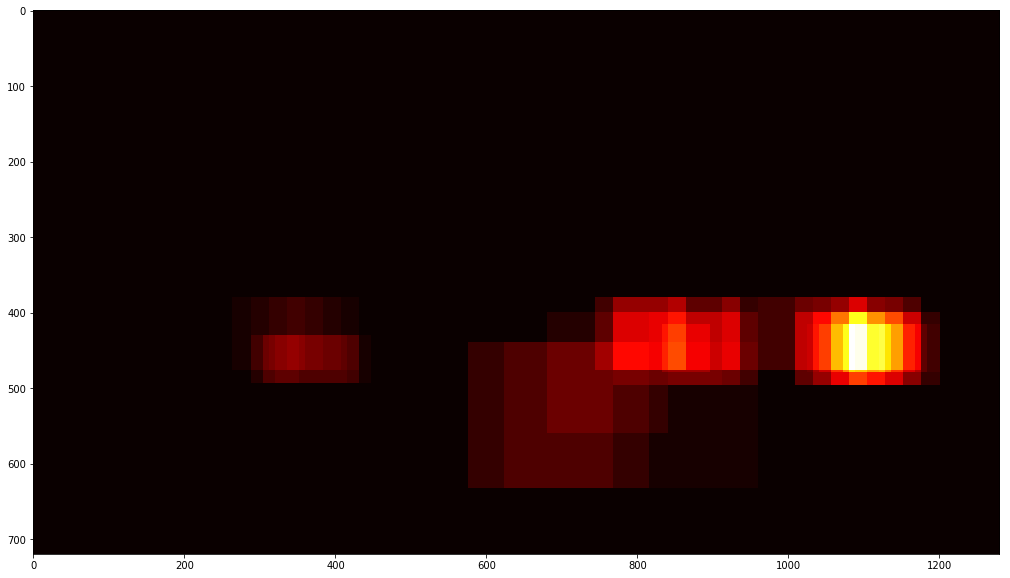

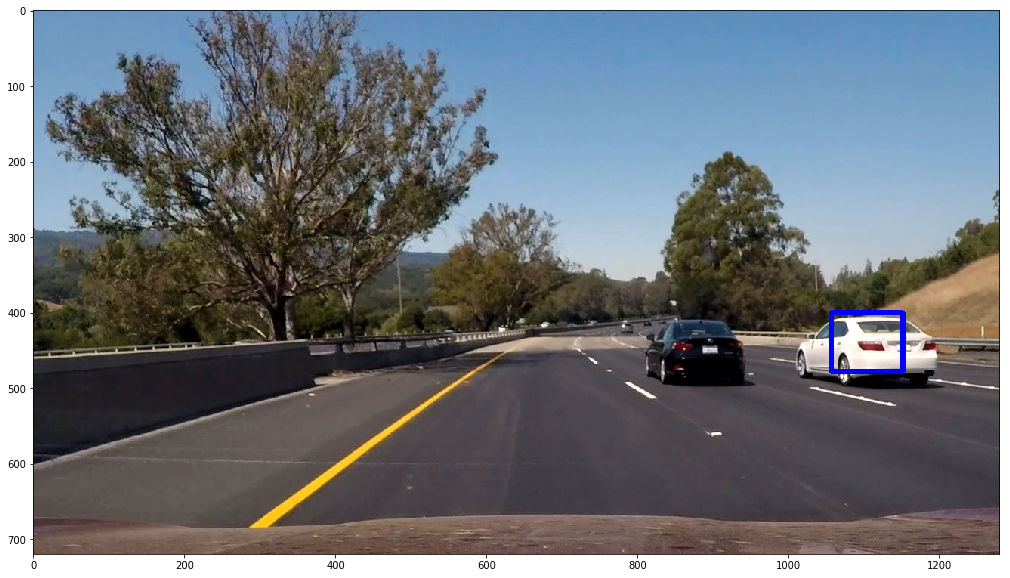

In [29]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

orient = 11
pix_per_cell = 16
cell_per_block = 2
cspace = cv2.COLOR_RGB2YUV
model = deserialize_model('YUV', orient, pix_per_cell, cell_per_block)
n_frames = 10

pipeline = DetectPipeline(model, orient, pix_per_cell, cell_per_block, cspace, n_frames)

out = 'test_video_out.mp4'
clip = VideoFileClip('test_video.mp4')
clip_out = clip.fl_image(pipeline.detect)
%time clip_out.write_videofile(out, audio=False)

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out))

In [25]:
orient = 11
pix_per_cell = 16
cell_per_block = 2
cspace = cv2.COLOR_RGB2YUV
model = deserialize_model('YUV', orient, pix_per_cell, cell_per_block)
n_frames = 10

pipeline = DetectPipeline(model, orient, pix_per_cell, cell_per_block, cspace, n_frames)

out = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4').subclip(0, 5)
clip_out = clip.fl_image(pipeline.detect)
%time clip_out.write_videofile(out, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [07:18<00:00,  2.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 11min 47s, sys: 12.4 s, total: 11min 59s
Wall time: 7min 20s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out))